In [7]:
# Import
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2
import time
from scipy.ndimage import filters


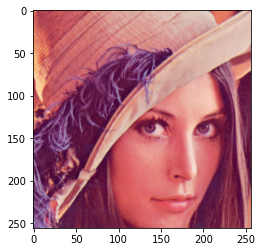

In [8]:
# (a) Crop the image and save as PNG
# Open the input image
input_image = Image.open("Lenna.png")

# Get the size of the input image
width, height = input_image.size

# Calculate the coordinates of the center of the image
center_x = width // 2
center_y = height // 2

# Calculate the size of the cropped region
crop_size = min(width, height) // 2

# Calculate the coordinates of the top-left corner of the cropped region
crop_x = center_x - crop_size // 2
crop_y = center_y - crop_size // 2

# Crop the image
cropped_image = input_image.crop((crop_x, crop_y, crop_x + crop_size, crop_y + crop_size))

# Save the cropped image as a PNG file
cropped_image.save("cropped_image.png", format="PNG")

# Display the cropped image using matplotlib
plt.imshow(cropped_image)
plt.show()

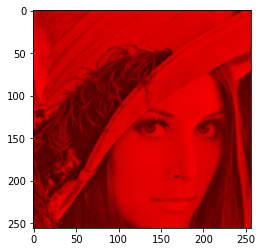

In [9]:
# (b) Extract the red channel of the image and display it
# Convert the cropped image to a NumPy array
red_channel = np.array(cropped_image)

# Extract the red channel of the cropped image by getting rid of blue and green channels
red_channel[:,:,1]=0
red_channel[:,:,2]=0

# Display the red channel using matplotlib
plt.imshow(red_channel)
plt.show()


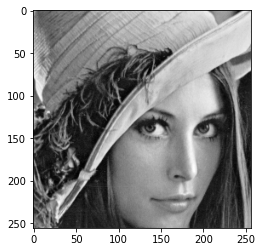

In [10]:
# (c) Convert the image to grayscale and display it
# Convert the cropped image to grayscale

gray_image = np.array(cropped_image)
r, g, b = gray_image[:,:,0], gray_image[:,:,1], gray_image[:,:,2]
gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
plt.imshow(gray, cmap="gray")
plt.show()

In [11]:
# # Load input image
# img = Image.open('cropped_image.png')

# # Convert image to grayscale
# img_gray = img.convert('L')

# # Save grayscale image as png
# img_gray.save('grayscale_image.png')

# # Display grayscale image
# plt.imshow(np.asarray(img_gray), cmap='gray')
# plt.show()

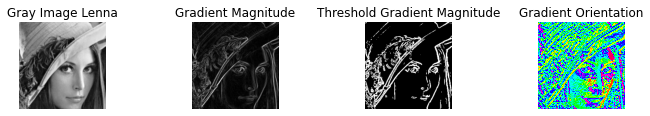

In [12]:
# (d) Apply Sobel filters to the grayscale image and display the results
# Apply Gaussian Blur to reduce noise
gray = cv2.GaussianBlur(gray, (3, 3), 0)

# Apply the Sobel filters to the grayscale image
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# Obtain the gradient magnitude and orientation
grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
grad_dir = np.arctan2(sobel_y, sobel_x)

# Normalize gradient magnitude to 0-255 range
grad_mag_norm = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# Threshold the image to obtain binary edge map
threshold_value = 50
_, threshold_edge_map = cv2.threshold(grad_mag_norm, threshold_value, 255, cv2.THRESH_BINARY)

# Display the gradient magnitude and orientation using matplotlib
plt.subplot(141)
plt.imshow(gray, cmap="gray")
plt.title("Gray Image Lenna")
plt.axis("off")
plt.subplot(142)
plt.imshow(grad_mag_norm, cmap="gray")
plt.title("Gradient Magnitude")
plt.axis("off")
plt.subplot(143)
plt.imshow(threshold_edge_map, cmap="gray")
plt.title("Threshold Gradient Magnitude")
plt.axis("off")
plt.subplot(144)
plt.imshow(grad_dir, cmap="hsv")
plt.title("Gradient Orientation")
plt.axis("off")
            
plt.subplots_adjust(
        left=0.1,
        bottom=0.1,
        right=1.5,
        top=0.9,
        wspace=1.)
plt.show()

In [13]:
# (e) Obtain Laplacian of Gaussian image for different sigma values and display the results

def laplace_of_gaussian(gray_img, sigma=1., kappa=0.75):

    assert len(gray_img.shape) == 2
    
    # Apply Gaussian Blur to reduce noise
    img = cv2.GaussianBlur(gray_img, (0, 0), sigma) if 0. < sigma else gray_img
    img = cv2.Laplacian(img, cv2.CV_64F)
    rows, cols = img.shape[:2]
    # min/max of 3x3-neighbourhoods
    min_map = np.minimum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    max_map = np.maximum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    # bool matrix for image value positiv (w/out border pixels)
    pos_img = 0 < img[1:rows-1, 1:cols-1]
    # bool matrix for min < 0 and 0 < image pixel
    neg_min = min_map < 0
    neg_min[1 - pos_img] = 0
    # bool matrix for 0 < max and image pixel < 0
    pos_max = 0 < max_map
    pos_max[pos_img] = 0
    # sign change at pixel?
    zero_cross = neg_min + pos_max
    # values: max - min, scaled to 0--255; set to 0 for no sign change
    value_scale = 255. / max(1., img.max() - img.min())
    values = value_scale * (max_map - min_map)
    values[1 - zero_cross] = 0.
    # optional thresholding
    if 0. <= kappa:
        thresh = float(np.absolute(img).mean()) * kappa
        values[values < thresh] = 0.
    log_img = values.astype(np.uint8)

    return log_img

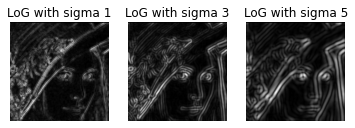

In [14]:
# (e) Obtain Laplacian of Gaussian image for different sigma values and display the results
# apply LoG
log_1 = laplace_of_gaussian(gray)
log_3 = laplace_of_gaussian(gray, sigma = 3.)
log_5 = laplace_of_gaussian(gray, sigma = 5.)

# display
plt.subplot(131)
plt.imshow(log_1, cmap="gray")
plt.title('LoG with sigma 1')
plt.axis("off")

plt.subplot(132)
plt.imshow(log_3, cmap="gray")
plt.title('LoG with sigma 3')
plt.axis("off")

plt.subplot(133)
plt.imshow(log_5, cmap="gray")
plt.title('LoG with sigma 5')
plt.axis("off")

plt.show()

In [15]:
# problem 2

# a

cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    
    
    # Apply Gaussian Blur to reduce noise
    gray_frame = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply the Sobel filters to the grayscale image
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Obtain the gradient magnitude and orientation
    grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

    # Normalize gradient magnitude to 0-255 range
    grad_mag_norm = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # Threshold the image to obtain binary edge map
    threshold_value = 25
    _, threshold_edge_map = cv2.threshold(grad_mag_norm, threshold_value, 255, cv2.THRESH_BINARY)

    # Display the resulting frame
    fps = cap.get(cv2.CAP_PROP_FPS)
    cv2.putText(frame, f"FPS: {int(fps)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Input', frame)
    cv2.imshow('Gradient Magnitude', grad_mag_norm)
    cv2.imshow('Threshold Gradient Magnitude', threshold_edge_map)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
# b

# Define the Sobel filters in x and y directions
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Define the duration for video recording in seconds
record_duration = 15

# Define the codec for saving the video file
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Open the webcam
cap = cv2.VideoCapture(0)

# Get the dimensions of the frames
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a video writer object to save the output video
out = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, (2*width, height))

# Start the timer for recording
start_time = time.time()

while(cap.isOpened()):
    # Capture a frame from the webcam
    ret, frame = cap.read()
    
    if ret:
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    

        # Apply Gaussian Blur to reduce noise
        gray_frame = cv2.GaussianBlur(gray, (3, 3), 0)

        # Apply the Sobel filters to the grayscale image
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        # Obtain the gradient magnitude and orientation
        grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

        # Normalize gradient magnitude to 0-255 range
        grad_mag_norm = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

        # Threshold the image to obtain binary edge map
        threshold_value = 25
        _, threshold_edge_map = cv2.threshold(grad_mag_norm, threshold_value, 255, cv2.THRESH_BINARY)

        # Concatenate the input frame and the gradient magnitude image side by side
        output_frame = np.concatenate((frame, cv2.cvtColor(grad_mag_norm, cv2.COLOR_GRAY2BGR)), axis=1)

        # Write the output frame to the video writer object
        out.write(output_frame)
        
        # Display the resulting frame
        cv2.imshow('Input', frame)
        cv2.imshow('Gradient Magnitude', grad_mag_norm)
        
        # Calculate the frame rate
        fps = 1.0 / (time.time() - start_time)

        # Display the frame rate on the input frame
        cv2.putText(frame, 'FPS: {:.2f}'.format(fps), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Break the loop if 'q' is pressed on the keyboard
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Stop recording if the specified duration is exceeded
        if time.time() - start_time > record_duration:
            break
    else:
        break

# Release the video capture and video writer objects
cap.release()
out.release()

# Close all windows
cv2.destroyAllWindows()